In [3]:
import boto3
import sagemaker

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mxnet as mx

%matplotlib inline

In [4]:
from sagemaker import get_execution_role
role = get_execution_role()
role

'arn:aws:iam::166807176553:role/service-role/AWSGlueServiceSageMakerNotebookRole-User-Data'

In [5]:
dataset = 's3://ufo-ml-project/ufo_fullset.csv'
dataset = pd.read_csv(dataset)
dataset.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


In [6]:
dataset.shape

(18000, 15)

In [7]:
geo_dataset = dataset[['latitude', 'longitude']].values.astype('float32')
print(geo_dataset)

[[  47.329445 -122.57889 ]
 [  52.664913   -1.034894]
 [  38.951668  -92.333885]
 ...
 [  36.86639   -83.888885]
 [  35.385834  -94.39833 ]
 [  29.883055  -97.94111 ]]


In [8]:
from sagemaker import KMeans

num_clusters=10
kmeans = KMeans(role=role,
                feature_dim=2,
                instance_count=1,
                instance_type='ml.c4.xlarge',
                output_path='s3://ufo-ml-project/cluster-results/',
                k=num_clusters
               )

In [9]:
%%time
kmeans.fit(kmeans.record_set(geo_dataset))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-01-13 06:52:34 Starting - Starting the training job...
2021-01-13 06:52:59 Starting - Launching requested ML instancesProfilerReport-1610520754: InProgress
......
2021-01-13 06:53:59 Starting - Preparing the instances for training.........
2021-01-13 06:55:29 Downloading - Downloading input data
2021-01-13 06:55:29 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/13/2021 06:55:47 INFO 140052614551360] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false'

In [10]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


---------------!CPU times: user 408 ms, sys: 1.53 ms, total: 409 ms
Wall time: 7min 32s


In [11]:
%%time
result=kmeans_predictor.predict(geo_dataset)

CPU times: user 1.07 s, sys: 15 ms, total: 1.08 s
Wall time: 1.78 s


In [12]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

In [13]:
pd.DataFrame(cluster_labels)[0].value_counts()

0.0    4001
4.0    3729
2.0    3124
7.0    2613
6.0    1698
5.0    1592
1.0     691
3.0     363
9.0     103
8.0      86
Name: 0, dtype: int64

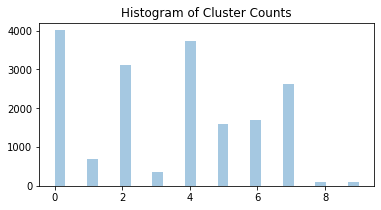

In [14]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

In [15]:
job_name = kmeans.latest_training_job.name
model_key = "cluster-results/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket('ufo-ml-project').download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')

0

In [16]:
Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [18]:
train_data = dataset[['latitude', 'longitude']]
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=train_data.columns

In [19]:
cluster_centroids

,latitude,longitude
0,39.697548,-86.564232
1,51.686779,0.918945
2,35.548935,-117.429535
3,9.143328,83.658051
4,41.186142,-75.020973
5,46.712433,-120.634438
6,28.008680,-80.742889
7,34.834545,-98.311371
8,26.280237,-145.149033
9,62.170712,-148.799774


In [35]:
os.listdir('/home/ec2-user/anaconda3')

['translations',
 'share',
 'include',
 'man',
 'qml',
 'sbin',
 'conda-meta',
 'lib',
 'shell',
 'x86_64-conda_cos6-linux-gnu',
 'bin',
 'var',
 'compiler_compat',
 'ssl',
 'PACKAGES_LICENSES',
 'envs',
 'LICENSE.txt',
 'mkspecs',
 'resources',
 'etc',
 'condabin',
 'doc',
 'phrasebooks',
 'plugins',
 'pkgs',
 'libexec']

In [36]:
os.environ['PROJ_LIB'] = '/home/ec2-user/anaconda3/share/proj'
%conda install basemap
from mpl_toolkits.basemap import Basemap

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - anaconda/linux-64::basemap==1.3.0=py36hee755e7_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - defaults/linux-64::numpy-base==1.18.1=py36hde5b4d6_1
  - defaults/linux-64::astropy==4.0=py36h7b6447c_0
  - defaults/linux-64::patsy==0.5.1=py36_0
  - defaults/linux-64::scikit-image==0.16.2=py36h0573a6f_0
  - defaults/linux-64::matplotlib-base==3.1.3=py36hef1b27d_0
  

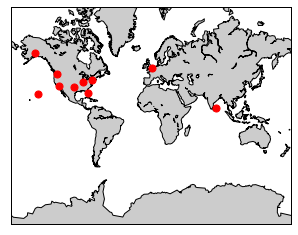

In [67]:
plt_map = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
plt_map.drawcoastlines()
plt_map.fillcontinents()
plt_map.drawmapboundary()
plt_map.scatter(x=np.array(cluster_centroids['longitude']), y=np.array(cluster_centroids['latitude']), latlon=True, c="#ff0000", s=50, zorder=2.5)
plt.show()